In [45]:
import os
import socket
import os
def find_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))
        return s.getsockname()[1]

os.environ["MASTER_PORT"] = str(find_free_port())
print(f"[INFO] Using MASTER_PORT={os.environ['MASTER_PORT']}")
from os.path import join, splitext
import json
from tqdm.notebook import tqdm
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from torchmetrics.classification import MultilabelAccuracy

from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights, resnet152,ResNet152_Weights
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

[INFO] Using MASTER_PORT=37795


In [30]:
data_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus'

In [31]:
class CheXpertDataset(Dataset):
    def __init__(self, root_dir, patient_id_set, transform=None):
        """
        Args:
            root_dir (str): Path to the parent directory containing subdirectories (e.g., 'label_folder').
            transform (callable, optional): Optional transform to be applied on an image.
            mode (str): Either "train" or "valid" to select the correct folder.
        """
        
        # self.label_folder = os.path.join(root_dir, 'chexbert_labels')
        self.root = root_dir
        self.img_path = os.path.join(self.root, 'PNG')
        self.img_folders = [folder for folder in os.listdir(self.img_path) if splitext(folder)[1] == '']

        self.label_folder = os.path.join(self.root, 'chexbert_labels')
        self.label_path = os.path.join(self.label_folder, 'findings_fixed.json')
        self.labels = []
        self.img_paths = []
        self.img_value_exception = 'train/patient32368/study1/view1_frontal.jpg'
        self.transform = transform
        
        # load a dictionary of image paths and labels
        with open(self.label_path, 'r') as f:
            label_data = []
            for line in f:
                label_data.append(json.loads(line))

        for label_dict in label_data:
            label_list_per_sample = []
            for key, value in label_dict.items():
                if key == 'path_to_image': # save image paths
                    split_values_list = splitext(value)[0].split('/')
                    patient_id = int(split_values_list[1][7:])
                    if value != self.img_value_exception and patient_id in patient_id_set:
                        value = '/'.join(split_values_list) + '.png'
                        for folder in self.img_folders:
                            img_subfolder_path = os.path.join(os.path.join(self.img_path, folder), 'PNG')
                            img_path = os.path.join(img_subfolder_path, value)
                            if os.path.exists(img_path):
                                self.img_paths.append(img_path)
                    else:
                        break # if img_path is not saved, neither will not its label be saved
                else: # save label vectors
                    if value is None: 
                        label_list_per_sample.append(0) # if this disease is not mentioned, it is perhaps not present
                    elif value == -1:
                        label_list_per_sample.append(0) # if radiologist is uncertain, chances of having this disease or being healthy are half half
                    else:
                        label_list_per_sample.append(value) # either having this disease or not
            if len(label_list_per_sample) > 0: # empty list implies this sample is not from this set of patients
                self.labels.append(torch.tensor(label_list_per_sample, dtype=torch.long))
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")  # convert to RGB
        if self.transform:
            img = self.transform(img)
        img = img.to(torch.float32)
        label = self.labels[idx]

        return img, label

In [32]:
!nvidia-smi

Thu Apr 17 10:50:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:1A:00.0 Off |                    0 |
| N/A   40C    P0            116W /  700W |  101167MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [33]:
num_gpus = torch.cuda.device_count()
print(f"Available GPUs: {num_gpus}")

Available GPUs: 1


In [34]:
class LitDenseNetMultiLabel(pl.LightningModule):
    def __init__(self, num_classes, lr=5e-5, weight_decay=1e-5):
        super().__init__()
        self.save_hyperparameters()

        weights = DenseNet121_Weights.DEFAULT
        self.model = densenet121(weights=weights)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)
        self.val_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)
        
        self.num_classes = num_classes
        self.val_preds = []
        self.val_targets = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())

        self.val_preds.append(preds.detach().cpu())
        self.val_targets.append(y.detach().cpu())

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())  # reuse val_acc for simplicity
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss


    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds)
        targets = torch.cat(self.val_targets).int()

        pred_labels = (preds > 0.5).int()

        # log confusion matrix per class
        cm = multilabel_confusion_matrix(targets, pred_labels)
        for i in range(self.num_classes):
            fig, ax = plt.subplots()
            ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
            ax.set_title(f"Confusion Matrix - Class {i}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            wandb.log({f"confusion_matrix_class_{i}": wandb.Image(fig)})
            plt.close(fig)

        # log ROC curves
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(targets[:, i], preds[:, i])
            roc_auc = auc(fpr, tpr)
            fig, ax = plt.subplots()
            ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_title(f"ROC Curve - Class {i}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc="lower right")
            wandb.log({f"roc_curve_class_{i}": wandb.Image(fig)})
            plt.close(fig)

        # clear stored predictions
        self.val_preds.clear()
        self.val_targets.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

In [35]:
class MultiLabelDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=16, num_workers=4):
        super().__init__()
        self.root = data_dir
        self.label_folder = os.path.join(self.root, 'chexbert_labels')
        self.label_path = os.path.join(self.label_folder, 'findings_fixed.json')
        self.train_patient_id_set = set()
        self.test_patient_id_set = set()

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = DenseNet121_Weights.DEFAULT.transforms()

    def setup(self, stage=None):
        # load a dictionary of image paths and labels
        with open(self.label_path, 'r') as f:
            label_data = []
            for line in f:
                label_data.append(json.loads(line))

        for label_dict in label_data:
            split_values_list = splitext(label_dict['path_to_image'])[0].split('/')
            mode = split_values_list[0] # train or test
            patient_id = int(split_values_list[1][7:])
            if mode == 'train':
                self.train_patient_id_set.add(patient_id)
            elif mode == 'valid':
                self.test_patient_id_set.add(patient_id)
        
        train_patient_id_list = list(self.train_patient_id_set)
        trainset_idx = np.random.choice(np.arange(len(train_patient_id_list)), int(0.75*len(train_patient_id_list)), replace=False)
        train_patient_id_set = set([train_patient_id_list[idx] for idx in trainset_idx])
        val_patient_id_set = self.train_patient_id_set - train_patient_id_set

        self.train_set = CheXpertDataset(root_dir=self.root, patient_id_set=train_patient_id_set, transform=self.transform)
        self.val_set = CheXpertDataset(root_dir=self.root, patient_id_set=val_patient_id_set, transform=self.transform)
        self.test_set = CheXpertDataset(root_dir=self.root, patient_id_set=self.test_patient_id_set, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers)

In [8]:
model = LitDenseNetMultiLabel(num_classes=14)
data = MultiLabelDataModule(data_dir=data_folder)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-{epoch}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)

wandb_logger = WandbLogger(project="chexpert_multilabel", name="lr_1e-3_batch_size_16")
# wandb_logger = WandbLogger(project="chexpert_multilabel")

trainer = pl.Trainer(
    max_epochs=8,
    accelerator='gpu',
    devices='auto',  # or specify a list like devices=[0,1]
    # strategy='ddp',  # distributed data parallel
    precision="16-mixed",     # optional mixed precision
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zhaizhongyuan (11785-bhiksha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /storage/ice1/1/7/zzhai37/nsp/cheXpert/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | DenseNet           | 7.0 M  | train
1 | loss_fn   | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MultilabelAccuracy | 0      | train
3 | val_acc   | MultilabelAccuracy | 0      | train
---------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.873    Total estimated model params size (MB)
436       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


In [41]:
model_densenet121 = LitDenseNetMultiLabel.load_from_checkpoint(
    "checkpoints/lr_5e-5_batch_size_256_best-epoch=2-val_loss=0.17.ckpt",
    num_classes=14  # same as used during training
)
# data = MultiLabelDataModule(data_dir=data_folder)
# data.setup('test')

In [38]:
len(data.test_patient_id_set)

200

In [46]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices='auto',  # or specify a list like devices=[0,1]
    # strategy='ddp',  # distributed data parallel
    precision="16-mixed",     # optional mixed precision
)

trainer.test(model, data)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9441391229629517
        test_loss           0.1706446260213852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1706446260213852, 'test_acc': 0.9441391229629517}]

In [7]:
lr = 5e-5
batch_size_list = [16, 32, 64, 128, 256]

In [4]:
val_acc = [0.94617, 0.94499, 0.94636, 0.94669, 0.94657]
# val_loss = [0.19404, 0.16852, 0.16686, 0.16955, 0.16585]
test_acc = [0.9432234764099121, 0.9413919448852539, 0.9438339471817017, 0.9413919448852539, 0.9441391229629517]
# test_loss = [0.17673853039741516, 0.1783837080001831, 0.1772538721561432, 0.17999115586280823, 0.1706446260213852]

In [24]:
colors = ['#e6194b',  # red-pink
          '#3cb44b',  # green
          '#ffe119',  # yellow
          '#4363d8',  # blue
          '#f58231',  # orange
          '#911eb4',  # purple
          '#46f0f0',  # cyan
          '#f032e6',  # magenta
          '#bcf60c',  # lime
          '#fabebe']  # pinkish-peach

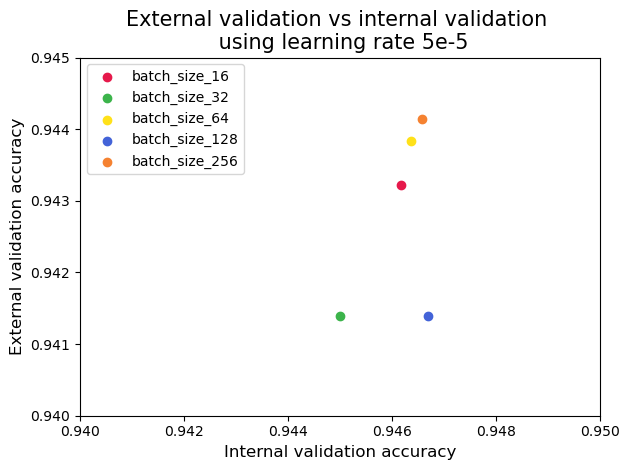

In [25]:
labels = [f'batch_size_{batch_size}' for batch_size in batch_size_list]

for i in range(len(val_acc)):
    plt.scatter(val_acc[i], test_acc[i], color=colors[i], label=labels[i])

plt.xlim([0.94, 0.95])
plt.ylim([0.94, 0.945])

plt.legend(loc='upper left')
plt.title('External validation vs internal validation \n using learning rate 5e-5', fontsize=15)
plt.xlabel('Internal validation accuracy', fontsize=12)
plt.ylabel('External validation accuracy', fontsize=12)
plt.tight_layout()
plt.savefig('External_vs_internal_validation.png', dpi=600)
plt.show()
# plt.plot(val_loss, test_loss, label='loss')

In [27]:
weights = ResNet152_Weights.DEFAULT
model = resnet152(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/hice1/zzhai37/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 87.4MB/s] 


In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
class LitResNetMultiLabel(pl.LightningModule):
    def __init__(self, num_classes, lr=5e-5, weight_decay=1e-5):
        super().__init__()
        self.save_hyperparameters()

        weights = ResNet152_Weights.DEFAULT
        self.model = resnet152(weights=weights)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)
        self.val_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)
        
        self.num_classes = num_classes
        self.val_preds = []
        self.val_targets = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())

        self.val_preds.append(preds.detach().cpu())
        self.val_targets.append(y.detach().cpu())

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())  # reuse val_acc for simplicity
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss


    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds)
        targets = torch.cat(self.val_targets).int()

        pred_labels = (preds > 0.5).int()

        # log confusion matrix per class
        cm = multilabel_confusion_matrix(targets, pred_labels)
        for i in range(self.num_classes):
            fig, ax = plt.subplots()
            ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
            ax.set_title(f"Confusion Matrix - Class {i}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            wandb.log({f"confusion_matrix_class_{i}": wandb.Image(fig)})
            plt.close(fig)

        # log ROC curves
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(targets[:, i], preds[:, i])
            roc_auc = auc(fpr, tpr)
            fig, ax = plt.subplots()
            ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_title(f"ROC Curve - Class {i}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc="lower right")
            wandb.log({f"roc_curve_class_{i}": wandb.Image(fig)})
            plt.close(fig)

        # clear stored predictions
        self.val_preds.clear()
        self.val_targets.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

In [42]:
model_resnet152 = LitResNetMultiLabel.load_from_checkpoint(
    "checkpoints/resnet_best-epoch=2-val_loss=0.17.ckpt",
    num_classes=14  # same as used during training
)

In [40]:
data = MultiLabelDataModule(data_dir=data_folder)
data.setup('test')

In [47]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices='auto',  # or specify a list like devices=[0,1]
    # strategy='ddp',  # distributed data parallel
    precision="16-mixed",     # optional mixed precision
)

trainer.test(model_resnet152, data)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9432234168052673
        test_loss           0.17125050723552704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17125050723552704, 'test_acc': 0.9432234168052673}]

In [50]:
class LitXceptionMultiLabel(pl.LightningModule):
    def __init__(self, num_classes, lr=5e-5, weight_decay=1e-5):
        super().__init__()
        self.save_hyperparameters()

        self.model = timm.create_model('xception', pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)
        self.val_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)

        self.num_classes = num_classes
        self.val_preds = []
        self.val_targets = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())

        self.val_preds.append(preds.detach().cpu())
        self.val_targets.append(y.detach().cpu())

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())  # reuse val_acc for simplicity
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds)
        targets = torch.cat(self.val_targets).int()

        pred_labels = (preds > 0.5).int()

        # log confusion matrix per class
        cm = multilabel_confusion_matrix(targets, pred_labels)
        for i in range(self.num_classes):
            fig, ax = plt.subplots()
            ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
            ax.set_title(f"Confusion Matrix - Class {i}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            wandb.log({f"confusion_matrix_class_{i}": wandb.Image(fig)})
            plt.close(fig)

        # log ROC curves
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(targets[:, i], preds[:, i])
            roc_auc = auc(fpr, tpr)
            fig, ax = plt.subplots()
            ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_title(f"ROC Curve - Class {i}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc="lower right")
            wandb.log({f"roc_curve_class_{i}": wandb.Image(fig)})
            plt.close(fig)

        # clear stored predictions
        self.val_preds.clear()
        self.val_targets.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

In [51]:
model_xception = LitXceptionMultiLabel.load_from_checkpoint(
    "checkpoints/xception_best-epoch=1-val_loss=0.17.ckpt",
    num_classes=14  # same as used during training
)

In [52]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices='auto',  # or specify a list like devices=[0,1]
    # strategy='ddp',  # distributed data parallel
    precision="16-mixed",     # optional mixed precision
)

trainer.test(model_xception, data)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9017093181610107
        test_loss           0.9270554780960083
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9270554780960083, 'test_acc': 0.9017093181610107}]

In [71]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl

class EnsembleModel(pl.LightningModule):
    def __init__(self, models):
        super().__init__()
        self.models = models
        for model in self.models:
            model.eval()  # freeze for inference

    def forward(self, x):
        with torch.no_grad():
            preds = [F.softmax(model(x), dim=1) for model in self.models]
            avg_preds = torch.stack(preds).mean(dim=0)
        return avg_preds

class EnsembleLightningWrapper(pl.LightningModule):
    def __init__(self, ensemble_model):
        super().__init__()
        self.ensemble_model = ensemble_model
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self.ensemble_model(x)
        loss = self.loss_fn(preds, y)
        acc = ((preds.sigmoid() > 0.5) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return {"loss": loss, "acc": acc}

ensemble_model = EnsembleModel([model_densenet121.model, model_resnet152.model, model_xception.model])
ensemble_model = ensemble_model.cuda()
wrapper = EnsembleLightningWrapper(ensemble_model)
predictions = trainer.test(wrapper, dataloaders=data.test_dataloader())

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `EnsembleLightningWrapper`

In [62]:
# Get predictions
predictions = trainer.test(ensemble_model, data)

# Convert to labels
preds = torch.cat(predictions)
labels = torch.cat([y for _, y in iter(data.test_dataloader())]).cuda()

# If multi-class:
ensemble_preds = preds.argmax(dim=1)
accuracy = (ensemble_preds == labels).float().mean()

print(f"Ensemble accuracy: {accuracy.item():.4f}")

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `EnsembleModel`